In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import json
import sys
import copy
import re
import os
from pathlib import Path
from itertools import chain
from functools import partial

import blpapi
# import clarion
import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
from IPython.display import display
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, Expr
from bqplot import LinearScale, ColorScale, OrdinalColorScale, OrdinalScale
from pandas.tseries.offsets import DateOffset, BDay
from pandas.tseries.frequencies import to_offset
from plotly import graph_objects as go, express as px
from plotly.subplots import make_subplots
# from clarion import positions


from api.gui.market_monitor import (
    CurvesViewer, 
    Pivot, 
    get_issuers_curves,
    get_issuer_curve
)
from api.gui.max_diff import LowestFieldCurve
from api.gui.visual import Visual
from api.gui.clarion_comp import Comp
from api.gui.cdx import CDXComp
from api.gui.scen_grid import Grid

from api.gui.base import View, Tabs, Store, store, router
from api.utils import parse_offset, today
from api.gui.market_monitor_h import (
    CurvesViewerH, 
    PivotH, 
    get_bond_ref, 
    get_bday, 
    get_history_table
)
from api.gui.max_diff_h import LowestFieldCurveH
from api.gui.visual_h import VisualH
from api.gui.fwd_pair_h import ForwardH
from api.gui.fwd_pivot_h import PivotForwardH

from api.blpw import BlpQuery
from api.bbg import BBGField, BBGOverrides
from api.data.base import data_path, tables
from api.data.curves import curves
from api.data.utils import add_pcs, parse_tenor
from api.pricing.cds import get_isda_cds
from api.data.processing import (
    apply_function, 
    add_years_to_maturity, 
    add_maturity_bucket,
    add_custom_rating,
    add_rating_bucket,
    add_geo_area
)

In [36]:
dt_fmt = '%Y-%m-%d'
bbg_dt_fmt = '%Y%m%d'

In [50]:
bq = BlpQuery(timeout=50000).start()

In [54]:
fx_bbg = {'EUR': 'EURUSD Curncy'}

class A:

    def __getattr__(self, item):
        bbg_sec = fx_bbg.get(item.upper())
        return bq.bdp([bbg_sec], ['px_last'])

In [55]:
a = A()

In [71]:
bh

date       security  last_price  yield_to_maturity  z_spread  \
0        2006-01-02  ED895557 Corp     102.185              7.433       NaN   
1        2006-01-02  EC356716 Corp     115.064              3.518       NaN   
2        2006-01-02  ED993708 Corp     100.375              6.145       NaN   
3        2006-01-02  EC373384 Corp     101.627              4.346       NaN   
4        2006-01-02  EC871207 Corp     107.003              3.381       NaN   
...             ...            ...         ...                ...       ...   
13732469 2022-10-24  AX185233 Corp      68.464              3.789   111.986   
13732470 2022-10-24  AZ191357 Corp      64.001              6.273   258.172   
13732471 2022-10-24  AW012814 Corp      85.066              6.547   279.681   
13732472 2022-10-24  BH621038 Corp      80.445              5.837   213.533   
13732473 2022-10-24  AR111365 Corp     100.117              3.316    35.721   

            risk source  
0         10.324    BGN  
1          5.111    BGN  
2          1.088    BGN  
3            NaN    BGN  
4          6.538    BGN  
...          ...    ...  
13732469  13.002   BVAL  
13732470   9.412   BVAL  
13732471  11.099   BVAL  
13732472  11.645   BVAL  
13732473   2.192   CBBT  

[13732474 rows x 7 columns]

In [70]:
bh.query('source == "BGN"').pivot(index='date', columns='security', values='z_spread')

security    912796R2 Govt  912796U4 Govt  912796U5 Govt  912796X3 Govt  \
date                                                                     
2006-01-02            NaN            NaN            NaN            NaN   
2006-01-03            NaN            NaN            NaN            NaN   
2006-01-04            NaN            NaN            NaN            NaN   
2006-01-05            NaN            NaN            NaN            NaN   
2006-01-06            NaN            NaN            NaN            NaN   
...                   ...            ...            ...            ...   
2022-10-18            NaN            NaN            NaN            NaN   
2022-10-19            NaN            NaN            NaN            NaN   
2022-10-20            NaN            NaN            NaN            NaN   
2022-10-21            NaN            NaN            NaN            NaN   
2022-10-24            NaN            NaN            NaN            NaN   

security    912796X5 Govt  912796X7 Govt  912796X8 Govt  912796X9 Govt  \
date                                                                     
2006-01-02            NaN            NaN            NaN            NaN   
2006-01-03            NaN            NaN            NaN            NaN   
2006-01-04            NaN            NaN            NaN            NaN   
2006-01-05            NaN            NaN            NaN            NaN   
2006-01-06            NaN            NaN            NaN            NaN   
...                   ...            ...            ...            ...   
2022-10-18            NaN            NaN            NaN            NaN   
2022-10-19            NaN            NaN            NaN            NaN   
2022-10-20            NaN            NaN            NaN            NaN   
2022-10-21            NaN            NaN            NaN            NaN   
2022-10-24            NaN            NaN            NaN            NaN   

security    912796YE Govt  912796YG Govt  ...  ZS539130 Corp  ZS562623 Corp  \
date                                      ...                                 
2006-01-02            NaN            NaN  ...            NaN            NaN   
2006-01-03            NaN            NaN  ...            NaN            NaN   
2006-01-04            NaN            NaN  ...            NaN            NaN   
2006-01-05            NaN            NaN  ...            NaN            NaN   
2006-01-06            NaN            NaN  ...            NaN            NaN   
...                   ...            ...  ...            ...            ...   
2022-10-18            NaN            NaN  ...         -0.484        113.791   
2022-10-19            NaN            NaN  ...          0.939        117.558   
2022-10-20            NaN            NaN  ...          2.609        119.287   
2022-10-21            NaN            NaN  ...         -0.500        122.910   
2022-10-24            NaN            NaN  ...          4.725        136.114   

security    ZS639039 Corp  ZS639051 Corp  ZS668078 Corp  ZS668080 Corp  \
date                                                                     
2006-01-02            NaN            NaN            NaN            NaN   
2006-01-03            NaN            NaN            NaN            NaN   
2006-01-04            NaN            NaN            NaN            NaN   
2006-01-05            NaN            NaN            NaN            NaN   
2006-01-06            NaN            NaN            NaN            NaN   
...                   ...            ...            ...            ...   
2022-10-18         40.909        116.734       1094.195       1043.000   
2022-10-19         41.854        114.286       1111.559       1052.709   
2022-10-20         40.644        112.228       1130.636       1063.534   
2022-10-21         42.099        120.407       1182.824       1107.479   
2022-10-24         41.168        120.619       1165.960       1097.564   

security    ZS841904 Corp  ZS842085 Corp  ZS915530 Corp  ZS939559 Corp  
date      

In [ ]:
tables.bonds_history

In [38]:
br = tables.bonds_reference
bh = pd.read_csv(data_path / 'bonds_history_all.csv', parse_dates=['date'], dayfirst=True)
cds_ref = pd.read_csv(data_path / 'cds_reference.csv')

In [39]:
# store = Store()
store.data['bond_ref'] = copy.deepcopy(get_bond_ref())
store.data['bond_ref_hist'] = get_bond_ref()
store.data['bond_hist'] = copy.deepcopy(bh)
store.data['cds_ref'] = copy.deepcopy(cds_ref)
store.bq = bq
# store.data['issuers_curves'] = copy.deepcopy(issuers_curves)

In [57]:
br.loc[br['security'] == 'EJ743592 Corp', 'rating_sp'] = 'BBB'

security  ticker                   name          isin currency  \
0     EJ743592 Corp  NGERIA  NGERIA 6 3/8 07/12/23  XS0944707222      USD   
1     EJ378603 Corp  DOMREP      DOMREP 7 07/31/23  XS0828446194      USD   
2     EJ713588 Corp  BHRAIN  BHRAIN 6 1/8 08/01/23  XS0956406135      USD   
3     EJ775396 Corp   ESKOM   ESKOM 6 3/4 08/06/23  XS0958072240      USD   
4     EJ795337 Corp  BOLIVI   BOLIVI 5.95 08/22/23  USP37878AB43      USD   
...             ...     ...                    ...           ...      ...   
2930  BY845256 Corp     BTF         BTF 0 12/07/22  FR0127316968      EUR   
2931  912796YG Govt       B             B 11/01/22  US912796YG81      USD   
2932  912796YN Govt       B             B 04/06/23  US912796YN33      USD   
2933  EG395336 Corp    FRTR    FRTR 4 1/4 10/25/23  FR0010466938      EUR   
2934  912796X9 Govt       B             B 01/05/23  US912796X959      USD   

     country bics_sector bics_industry  amount_issued issue_date  ...  \
0         NG  Government    Sovereigns   5.000000e+08 2013-07-12  ...   
1         DO  Government    Sovereigns   5.000000e+08 2012-07-31  ...   
2         BH  Government    Sovereigns   1.500000e+09 2013-08-01  ...   
3         ZA   Utilities     Utilities   1.000000e+09 2013-08-06  ...   
4         BO  Government    Sovereigns   5.000000e+08 2013-08-22  ...   
...      ...         ...           ...            ...        ...  ...   
2930      FR  Government    Sovereigns   8.733000e+09 2022-09-07  ...   
2931      US  Government    Sovereigns   1.301230e+11 2022-07-05  ...   
2932      US  Government    Sovereigns   4.727200e+10 2022-10-06  ...   
2933      FR  Government    Sovereigns   4.491800e+10 2007-05-09  ...   
2934      US  Government    Sovereigns   1.096240e+11 2022-07-07  ...   

     is_convertible is_subordinated  payment_rank issuer_equity_ticker  \
0                 N               N  Sr Unsecured          1369612D NL   
1                 N               N     Unsecured          1501569D US   
2                 N               N  Sr Unsecured          1250658D BI   
3                 N               N  Sr Unsecured             1001Z SJ   
4                 N               N  Sr Unsecured          1501625D VB   
...             ...             ...           ...                  ...   
2930              N               N     Unsecured          1501899D FP   
2931              N             NaN     Unsecured          1501487D US   
2932              N             NaN     Unsecured          1501487D US   
2933              N               N     Unsecured          1501888D FP   
2934              N             NaN     Unsecured          1501487D US   

                 issuer_name       bmk_bond           cds_ticker_5y  \
0        REPUBLIC OF NIGERIA  91282CER Govt  CT393726 Curncy Curncy   
1         DOMINICAN REPUBLIC  91282CER Govt                     NaN   
2         KINGDOM OF BAHRAIN  91282CER Govt  CT393413 Curncy Curncy   
3     ESKOM HOLDINGS SOC LTD  91282CER Govt  CT971829 Curncy Curncy   
4         BOLIVIA GOVERNMENT  91282CER Govt  CY562492 Curncy Curncy   
...                      ...            ...                     ...   
2930  FRENCH DISCOUNT T-BILL  BY845256 Corp         CFRTR1U5 Curncy   
2931           TREASURY BILL  912796YG Govt         CT786896 Curncy   
2932           TREASURY BILL  912796YN Govt         CT786896 Curncy   
2933        FRANCE (GOVT OF)  BY973184 Corp         CFRTR1U5 Curncy   
2934           TREASURY BILL  912796X9 Govt         CT786896 Curncy   

     custom_rating rating_bucket has_history  
0               B-             B        True  
1              NaN           NaN        True  
2               B+             B        True  
3             CCC+           CCC        True  
4               B+             B        True  
...            ...           ...         ...  
2930           NaN           NaN        True  
2931           NaN           NaN        True  
2932           NaN           NaN        True

In [ ]:
d1 = '2022-01-01'

In [ ]:
d2 = pd.to_datetime(d1)

In [ ]:
'EI466093 Corp'

In [ ]:
pcs = 'BGN'

In [ ]:
sec = 'EI466093 Corp'

In [ ]:
s1, s2 = sec.split(' ')

In [62]:
br

security  ticker                   name          isin currency  \
0     EJ743592 Corp  NGERIA  NGERIA 6 3/8 07/12/23  XS0944707222      USD   
1     EJ378603 Corp  DOMREP      DOMREP 7 07/31/23  XS0828446194      USD   
2     EJ713588 Corp  BHRAIN  BHRAIN 6 1/8 08/01/23  XS0956406135      USD   
3     EJ775396 Corp   ESKOM   ESKOM 6 3/4 08/06/23  XS0958072240      USD   
4     EJ795337 Corp  BOLIVI   BOLIVI 5.95 08/22/23  USP37878AB43      USD   
...             ...     ...                    ...           ...      ...   
2930  BY845256 Corp     BTF         BTF 0 12/07/22  FR0127316968      EUR   
2931  912796YG Govt       B             B 11/01/22  US912796YG81      USD   
2932  912796YN Govt       B             B 04/06/23  US912796YN33      USD   
2933  EG395336 Corp    FRTR    FRTR 4 1/4 10/25/23  FR0010466938      EUR   
2934  912796X9 Govt       B             B 01/05/23  US912796X959      USD   

     country bics_sector bics_industry  amount_issued issue_date  ...  \
0         NG  Government    Sovereigns   5.000000e+08 2013-07-12  ...   
1         DO  Government    Sovereigns   5.000000e+08 2012-07-31  ...   
2         BH  Government    Sovereigns   1.500000e+09 2013-08-01  ...   
3         ZA   Utilities     Utilities   1.000000e+09 2013-08-06  ...   
4         BO  Government    Sovereigns   5.000000e+08 2013-08-22  ...   
...      ...         ...           ...            ...        ...  ...   
2930      FR  Government    Sovereigns   8.733000e+09 2022-09-07  ...   
2931      US  Government    Sovereigns   1.301230e+11 2022-07-05  ...   
2932      US  Government    Sovereigns   4.727200e+10 2022-10-06  ...   
2933      FR  Government    Sovereigns   4.491800e+10 2007-05-09  ...   
2934      US  Government    Sovereigns   1.096240e+11 2022-07-07  ...   

     is_convertible is_subordinated  payment_rank issuer_equity_ticker  \
0                 N               N  Sr Unsecured          1369612D NL   
1                 N               N     Unsecured          1501569D US   
2                 N               N  Sr Unsecured          1250658D BI   
3                 N               N  Sr Unsecured             1001Z SJ   
4                 N               N  Sr Unsecured          1501625D VB   
...             ...             ...           ...                  ...   
2930              N               N     Unsecured          1501899D FP   
2931              N             NaN     Unsecured          1501487D US   
2932              N             NaN     Unsecured          1501487D US   
2933              N               N     Unsecured          1501888D FP   
2934              N             NaN     Unsecured          1501487D US   

                 issuer_name       bmk_bond           cds_ticker_5y  \
0        REPUBLIC OF NIGERIA  91282CER Govt  CT393726 Curncy Curncy   
1         DOMINICAN REPUBLIC  91282CER Govt                     NaN   
2         KINGDOM OF BAHRAIN  91282CER Govt  CT393413 Curncy Curncy   
3     ESKOM HOLDINGS SOC LTD  91282CER Govt  CT971829 Curncy Curncy   
4         BOLIVIA GOVERNMENT  91282CER Govt  CY562492 Curncy Curncy   
...                      ...            ...                     ...   
2930  FRENCH DISCOUNT T-BILL  BY845256 Corp         CFRTR1U5 Curncy   
2931           TREASURY BILL  912796YG Govt         CT786896 Curncy   
2932           TREASURY BILL  912796YN Govt         CT786896 Curncy   
2933        FRANCE (GOVT OF)  BY973184 Corp         CFRTR1U5 Curncy   
2934           TREASURY BILL  912796X9 Govt         CT786896 Curncy   

     custom_rating rating_bucket has_history  
0               B-             B        True  
1              NaN           NaN        True  
2               B+             B        True  
3             CCC+           CCC        True  
4               B+             B        True  
...            ...           ...         ...  
2930           NaN           NaN        True  
2931           NaN           NaN        True  
2932           NaN           NaN        True

In [ ]:
f"{s1}@{pcs} {s2}"

In [61]:
res = bq.bdp(
    securities=['EI466093 Corp', 'EJ378603 Corp'],
    fields=['TICKER', 'SECURITY_DES'],
    # overrides=[('pcs', 'CBBT')],
    pcs='BVAL',
    sep='@'
)
res

security  TICKER         SECURITY_DES
0  EI466093 Corp    PERU  PERU 5 5/8 11/18/50
1  EJ378603 Corp  DOMREP    DOMREP 7 07/31/23

In [ ]:
res['security'].str.replace(f'@{pcs}', '')

In [ ]:
w.HBox()


In [4]:
import bhutils as bh
from api import ezutils as ez

In [6]:
isin = [
    'US195325EA91'
]

In [11]:
bond_handle = bh.bhBondRead('bond_handle', isin[0], ez.mx_cals)

In [15]:
p = bq.bdp(
    securities=isin,
    fields=['px_last'],
    security_type='isin'
)

In [20]:
price = p['px_last'].squeeze()
horizon = '3M'

In [18]:
repo_rate = -50

In [16]:
d1 = today()
d2 = bh.bhBondSettlementDate(bond_handle, d1)

In [23]:
spot_yld = bh.bhBondYTM(bond_handle, d2, price)

In [25]:
fwd_yield = bh.bhBondFwdYtM(
    bond_handle,
    _settlement=d2,
    _horizon=bh.bhBump(d2, horizon),
    _price=price,
    _reporate=repo_rate / 100000
)

In [27]:
carry = fwd_yield - spot_yld

0.002373620000000007

In [29]:
bh.bhCAObjectShow("{OBJECT_TYPE}","*")


array([['KEY', 'VALUE'],
       ['<EMPTY>', '<EMPTY>']], dtype=object)

In [22]:
class Matt(View):
    
    def make_widgets(self, **kwargs):
        
    def make_view(self, **kwargs):
        self.view = w.IntSlider()

In [46]:
class Equity:
    def __init__(self, ts=None):
        self.prices = ts
    @property
    def returns(self):
        self.prices.pct_change()
        
    @property
    def a(self):
        if hasattr(self, '_a'):
            return self._a
    
    @a.setter
    def a(self, value):
        if isinstance(value, int):
            self._a = value
        else:
            raise ValueError(f'property a can only be an int but got {type(value)} instead')
    

In [47]:
a = Equity()

In [51]:
a.a = 3

In [52]:
a.a

3

In [41]:
a.a = 5

AttributeError: can't set attribute

In [33]:
A().a

2

In [34]:
m = Matt()

In [35]:
m.store 

{'router': <api.gui.base.Router object at 0x000001B4E11DE100>, 'matt': <__main__.Matt object at 0x000001B4F5DBA880>, 'matt2': <__main__.Matt object at 0x000001B4F5DC4E80>, 'test1': <__main__.Matt object at 0x000001B4F5DC4FD0>, 'matt4': <__main__.Matt object at 0x000001B4D1B76A60>, 'matt5': <__main__.Matt object at 0x000001B4F5DC3700>}

In [28]:
store['test1'].view.value

46

In [30]:
store

{'router': <api.gui.base.Router object at 0x000001B4E11DE100>, 'matt': <__main__.Matt object at 0x000001B4F5DBA880>, 'matt2': <__main__.Matt object at 0x000001B4F5DC4E80>, 'test1': <__main__.Matt object at 0x000001B4F5DC4FD0>, 'matt4': <__main__.Matt object at 0x000001B4D1B76A60>}

In [18]:
# from IPython.display import display
class A:
    html = '<h1> I am A </h3>'
    
    def __repr__(self):
        return 'I am child of A'
    
    def _ipython_display_(self):
        display(w.DatePicker())

In [19]:
A()

DatePicker(value=None)

In [30]:
bh.bhCAObjectShow(["{OBJECT_TYPE}","{OBJECT_HANDLE}"],["MODEL","risky"])



array([['KEY', 'VALUE'],
       ['<EMPTY>', '<EMPTY>']], dtype=object)

In [53]:
df = pd.read_clipboard()

In [113]:
def get_pivot_table(df, value, index='offset'):
    df_ = df.pivot(index=index, columns='maturity_label', values=value)
    try:
        df_ = df_.astype(float)
    except:
        pass
    
    return df_.loc[[*df[index].unique()]]

In [57]:
df_plot = get_pivot_table(df , 'hr')

In [59]:
fig = df_plot.T.plot(template='plotly_white')

In [101]:
def make_plot(df, **kwargs):
    fig = df.plot(
        x='maturity_label',
        y='hr', 
        color='offset',
        hover_data=['name'],
        template='plotly_white',
        height=500
    ).update_layout(
        xaxis = dict(
            tickmode='array', #change 1
            tickvals = df['maturity_label'].unique(), #change 2
            #ticktext = [0,5,10,15,20,25],  
        ),
        yaxis=dict(tickformat='.1%'),
        # font=dict(size=18, color="black")
    )
    return fig


def make_dg(data):
    renderer = TextRenderer(
        format='.2f',
        horizontal_alignment="center",
    )

    pct_renderer = TextRenderer(
        format='.2%',
        horizontal_alignment="center",
    )
    pct_cols = [
        "hr",
        "surv",
    ]

    date_renderer = TextRenderer(
        format="%Y-%m-%d",
        format_type="time",
        horizontal_alignment="center",
    )

    renderers = {
        **{col: renderer for col in data.columns if data[col].dtype == 'float64'},
        'date': date_renderer
    }
    renderers.update({col: pct_renderer for col in pct_cols})

    dg = DataGrid(
        data,
        selection_mode='cell',
        base_column_size=70,
        column_widths={'date': 90, 'name': 150},
        renderers=renderers,
        editable=True,
    )

    return dg


fmt_map = {
    'hr': '.2%',
    'surv': '.2%',
    'z_spread': '.2f'
}


def make_dg2(data, field, fmt=None):
    df = get_pivot_table(data, field)
    fmt = fmt or fmt_map.get(field)
    dg = DataGrid(df, default_renderer=TextRenderer(format=fmt))
    return dg

In [121]:
fmt_map = {
    'hr': '.2%',
    'surv': '.2%',
    'z_spread': '.2f'
}

def make_dg2(data, field, fmt=None):
    df = get_pivot_table(data, field)
    fmt = fmt or fmt_map.get(field)
    dg = DataGrid(df, default_renderer=TextRenderer(format=fmt))
    return dg

In [122]:
make_dg2(data, 'surv')

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [114]:
d = get_pivot_table(data, 'hr')

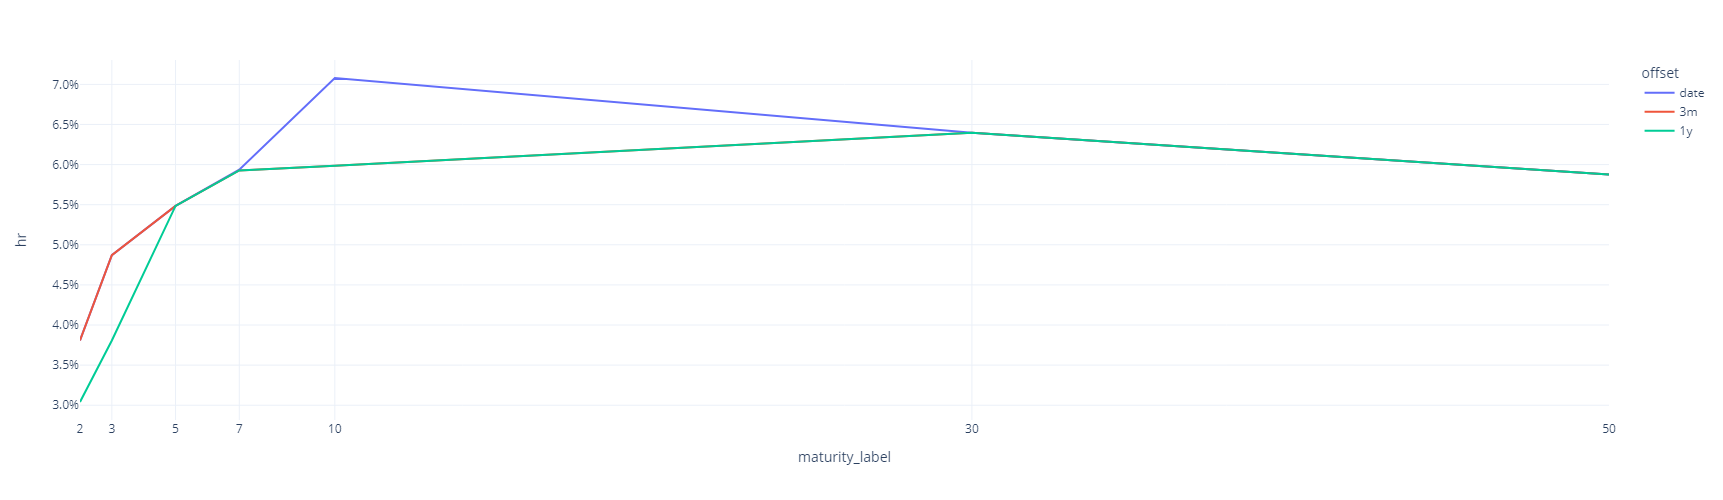

In [93]:
fig.update_layout(
    xaxis = dict(
        tickmode='array', #change 1
        tickvals = df['maturity_label'].unique(), #change 2
        #ticktext = [0,5,10,15,20,25],  
    ),
    yaxis=dict(tickformat='.1%'),
    # font=dict(size=18, color="black")
)